# Model Training

Exploring Pytorch Neural Network support modules by create and training a model.

In [4]:
import gzip
import math
import os
import pickle
import shutil
import time
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from fastcore.test import test_close
from torch import nn, tensor

In [107]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data

In [6]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

### Pytorch Model
Derive the model from the Pytorch nn module which support neural network

In [7]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [8]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

#### Softmax (softargmax)
A function that take the vector of input value and convert them to output value as probability between 0 and 1.
The input value may be zero, negative, positive.

Sometime it is called multi-class logistic regression function. Since it's used as final output for them.
Many Neural Network output value that are not suitable for output so they must be convert using softmax.

Softmax is the generalize version of sigmoid function since softmax take vector as input and output a vector while sigmoid takes a scalar value and output a scalar.

First, we will need to compute the softmax of our activations. This is defined by:

$\color{chocolate}{ \sigma : \R^K\to (0,1)^K}$ is defined when $\color{chocolate}{ K \ge 1 }$ by the formula

$$\color{chocolate}{ \hbox{softmax(x)}_{i} = \sigma(x)_i   = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}} }\ \text{ for } i = 1, \dotsc , K \text{ and } \mathbf x=(x_1,\dotsc,x_K) \in\R^K  $$

or more concisely:

$$\color{chocolate}{\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}} }$$ 
input vector $\color{chocolate}{x}$ and normalizes these values by dividing by the sum of all these exponentials; this normalization ensures that the sum of the components of the output vector $\color{chocolate}{ \sigma(x)}$ is  $\color{chocolate}{1}$. 


#### Argmax function
The argmax function convert all the value in the input vector to zero except the max value in the vector. Which it's convert to one with the result of vector of all zero except one value that is one. 

The arg max function can be considered as *one-hot* or *look-up table* representation of the output (assuming there is a unique maximum arg):
$$\color{chocolate}{\operatorname{arg\,max}(x_1, \dots, x_n) = (y_1, \dots, y_n) = (0, \dots, 0, 1, 0, \dots, 0),}$$

#### Softmax vs Argmax
The softmax can be considered as a *smoother* version of the arg max where the value in the output vector are either $\color{chocolate}{0}$ or $\color{chocolate}{1}$.

code in Python

```python
import numpy as np
a = [1.0,2.0,3.0,4.0,1.0,3.0]
np.exp(a) / np.sum(np.exp(a))
```
code in Julia
```julia
A = [1.0,2.0,3.0,4.0,1.0,3.0]
exp.(A) ./ sum(exp.(A))

```


---
#### Log
Using log to simply and speed up compute by convert division to substraction and avoid over and unflow when compute using floating point.

In practice, we will need the log of the softmax when we calculate the loss.

In [9]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [10]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

Note that the formula 

$$\color{chocolate}{ \log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)}$$ 

gives a simplification when we compute the log softmax, which was previously defined as $\color{chocolate}{ (x.exp()/(x.exp().sum(-1,keepdim=True))).log()}$

In [11]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\color{chocolate}{ \log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )}$$

where $\color{chocolate}{ a }$ is the maximum of the $\color{chocolate}{ x_{j}}$.

In [12]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [13]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [14]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

### Cross entropy loss

Cross entropy is the measurement of randomness of one distribution of data relate to another distribution. In this case the prediction of data relate to the actual input data. It's measure the loss of the prediction against the actual dataset.

Using cross entropy loss from Pytorch since it's already provided.



The cross entropy loss for some target $\color{chocolate}{ x}$ and some prediction $\color{chocolate}{ p(x)}$ is given by:

$$ \color{chocolate}{ -\sum x\, \log p(x) }$$

But since our $ \color{chocolate}{ x} $ are *1-hot* encoded, this can be rewritten as $\color{chocolate}{ -\log(p_{i})}$ where  $\color{chocolate}{i}$ is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [15]:
y_train[:3]

tensor([5, 0, 4])

In [16]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [17]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

#### Negative Log Likelihood (NLL)
When using logarithm to compute value that less than 1 (probability) is result in negative value. 
- log 1 = 0 
- log .5 = -0.301
- log .9 = -0.045
- log .1 = -1

The minus sign is used to negate the result to make it positive. Likelihood == probability

In [18]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [19]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [20]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [21]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [22]:
loss_func = F.cross_entropy

In [23]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [24]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [25]:
torch.argmax(preds, dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5, 3, 9, 3, 8, 9, 5, 9, 5, 9, 5, 8, 8, 9, 8])

In [26]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [27]:
accuracy(preds, yb)

tensor(0.09)

In [28]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [115]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        if i==0: print(loss.item(), accuracy(preds, yb).item())
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

0.06854070723056793 0.984375


AttributeError: 'Sequential' object has no attribute 'layers'

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__`:

In [30]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    def __call__(self, x): return self.l2(self.relu(self.l1(x)))

In [31]:
model = Model(m, nh, 10)

In [32]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [33]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [34]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [35]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            if i==0: print(loss.item(), accuracy(preds, yb).item())
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [36]:
fit()

2.309434175491333 0.0625
0.20068752765655518 0.953125
0.18196910619735718 0.9375


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [37]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [38]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [39]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

In [40]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [41]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [42]:
model = Model(layers)

In [43]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

Pytorch module that hold all the modules in the list

`nn.ModuleList` does this for us.

In [44]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [45]:
model = SequentialModel(layers)

In [46]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [47]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

2.3222596645355225 0.03125
0.14386771619319916 0.96875
0.08797655254602432 0.96875


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [48]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [49]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

2.3087124824523926 0.09375
0.2031664401292801 0.90625
0.20330601930618286 0.921875


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

In [50]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

The Pytorch optimization module

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [51]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [52]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [53]:
opt = Optimizer(model.parameters())

In [54]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        if i==0: print(loss.item(), accuracy(preds, yb).item())

        opt.step()
        opt.zero_grad()

2.30017352104187 0.0625
0.1306794285774231 0.96875
0.12934736907482147 0.96875


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [55]:
from torch import optim

In [56]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [57]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [58]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        if i==0: print(loss.item(), accuracy(preds, yb).item())
        opt.step()
        opt.zero_grad()

2.312685012817383 0.078125
0.2142210155725479 0.90625
0.1782902181148529 0.921875


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [59]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [60]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [61]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [62]:
model,opt = get_model()

In [63]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        pred = model(xb)
        loss = loss_func(pred, yb)
        if i==0: print(loss.item(), accuracy(pred, yb).item())

        loss.backward()
        opt.step()
        opt.zero_grad()

2.2979648113250732 0.09375
0.21198970079421997 0.953125
0.17290513217449188 0.921875


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [64]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [65]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [66]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([64, 784])

In [67]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])

tensor(3)

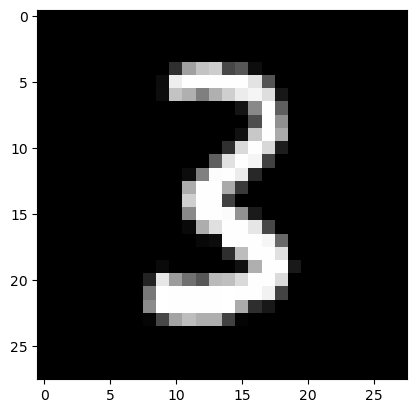

In [68]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [69]:
model,opt = get_model()

In [70]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [71]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(1.))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [72]:
import random

In [73]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [74]:
from itertools import islice

In [75]:
ss = Sampler(train_ds)

In [76]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [77]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [78]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[12688, 21067, 29356, 38440, 7564]

In [79]:
import fastcore.all as fc

In [80]:
 class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last) # type: ignore

In [81]:
batchs = BatchSampler(ss, 4) # type: ignore
list(islice(batchs, 5)

[[25974, 37990, 1790, 15011],
 [34475, 9288, 2705, 28301],
 [24526, 29599, 36012, 5800],
 [35646, 39278, 49120, 22040],
 [26849, 49829, 34720, 44465]]

In [82]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [83]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)  # type: ignore

In [84]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [85]:
train_dl = DataLoader(train_ds, batchs=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batchs=valid_samp, collate_fn=collate)

tensor(3)

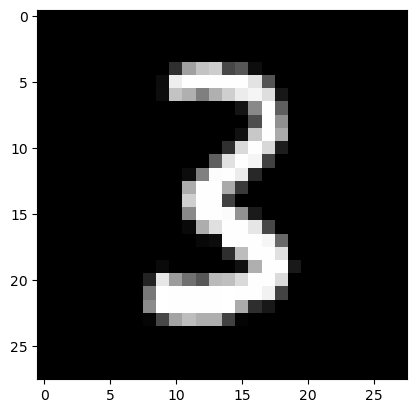

In [86]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [87]:
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [88]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.08, grad_fn=<NllLossBackward0>), tensor(0.95))

### Multiprocessing DataLoader

In [89]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [90]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))  # type: ignore

In [91]:
train_dl = DataLoader(train_ds, batchs=train_samp, collate_fn=collate, n_workers=2)
it = iter(train_dl)

In [ ]:
xb,yb = next(it)
xb.shape,yb.shape

### PyTorch DataLoader

In [93]:
from torch.utils.data import (BatchSampler, DataLoader, RandomSampler,
                              SequentialSampler)

In [94]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [95]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)  # type: ignore
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)  # type: ignore

In [96]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

PyTorch can auto-generate the BatchSampler for us:

In [97]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)  # type: ignore
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)  # type: ignore

PyTorch can also generate the Sequential/RandomSamplers too:

In [98]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)# type: ignore
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)     # type: ignore

In [99]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

Our dataset actually already knows how to sample a batch of indices all at once:

In [100]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [101]:
train_dl = DataLoader(train_ds, sampler=train_samp) # type: ignore
valid_dl = DataLoader(valid_ds, sampler=valid_samp) # type: ignore

In [102]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 64, 784]), torch.Size([1, 64]))

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [104]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count # type: ignore

In [105]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [106]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.1520686897546053 0.9545
1 0.15295425002872945 0.9503
2 0.09883106732219457 0.9718
3 0.09758859654664993 0.9721
4 0.11875128887742757 0.9667
